In [1]:
import os
import numpy as np

import cv2


from scipy import ndimage as ndi
from scipy.signal import find_peaks


# from skimage import (exposure, feature, filters, io, measure,
#                       morphology, restoration, segmentation, transform,
#                       util,draw)


import matplotlib.pyplot as plt
import pyvista as pv


import pandas as pd

In [2]:
# Define the file path and data type
file = '../data/NEAPEL/Neapel CT/TL_1-12/TL_1-12_2016x1198x211_0.00833.raw'
dtype = np.uint16  # Change this to the appropriate data type (e.g., np.uint8, np.int16, etc.)
shape = (2016, 211, 1198)  # Define the shape of the array (e.g., (height, width))


print(os.path.exists(file))
print(os.path.isfile(file))

True
True


In [7]:
# Read the binary data from the file into a NumPy array
try:
    with open(file, 'rb') as f:
        data = np.fromfile(f, dtype=dtype)
        print(data.nbytes/1024**2)
        # If you have a specific shape, reshape the array accordingly
        if shape:
            data = data.reshape(shape)
except FileNotFoundError:
    print(f"File '{file}' not found.")
    data = None

if data is not None:
    print(f"File '{file}' was loaded")

971.9857177734375
File '../data/NEAPEL/Neapel CT/TL_1-12/TL_1-12_2016x1198x211_0.00833.raw' was loaded


In [8]:
# convert the data form uint16 to float 32
data = data.astype(np.float32)
print(data.nbytes/1024**2)
#normalize the data range 0-1
data = (data - data.min()) / (data.max() - data.min())
## convert to uint8 data range 0:255
data = (data*255).astype(np.uint8)
# data = raw_data

1943.971435546875


In [5]:
print(data.nbytes/1024**2)

485.99285888671875


In [6]:
# Check if everything is right
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(np.min(data), np.max(data)))

shape: (2016, 211, 1198)
dtype: uint8
range: (0, 255)


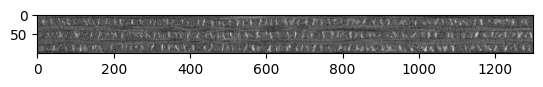

In [11]:
plt.imshow(data[500:1800,50:150,65].transpose(1,0),cmap='gray')

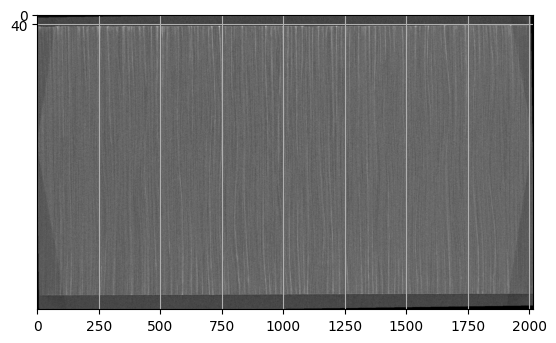

In [13]:
data = ndi.rotate(data, -.78,axes=(0,2), reshape=False)

plt.imshow(data[:,70,:].transpose(1,0),cmap='gray')
plt.imshow(data[:,70,:].transpose(1,0),cmap='gray')
plt.yticks([0,40])
plt.grid(which='both')

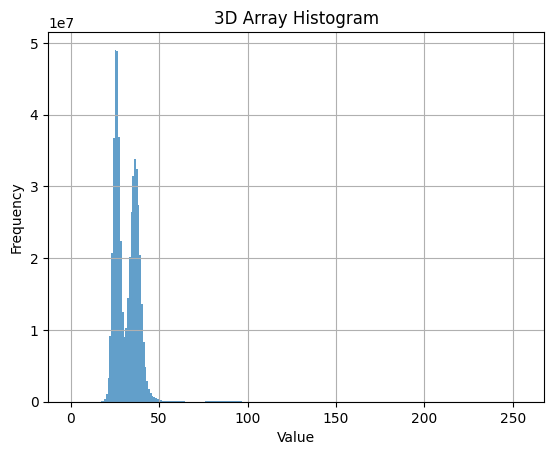

In [14]:
bin_range= [0, 255]
num_bins = 256

hist, bins = np.histogram(data.flatten(), bins=num_bins, range=bin_range)

# Plot the histogram
plt.hist(data.flatten(), bins=num_bins, range=bin_range, color='tab:blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('3D Array Histogram')
plt.grid(True)
plt.show()

## Some Magic


In [15]:
data_max = ndi.maximum_filter(data,size=(2,2,10))

Text(0.5, 1.0, 'maximum filtered ../data/NEAPEL/Neapel CT/TL_1-12/TL_1-12_2016x1198x211_0.00833.raw')

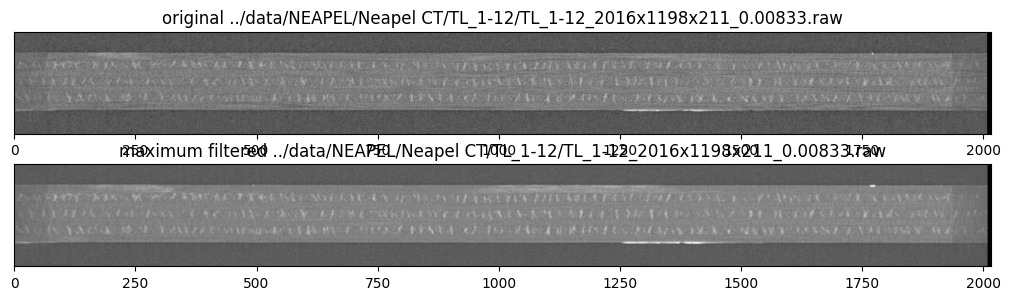

In [16]:
fig,axs = plt.subplots(2,1,figsize=(2*6.3,6.3/2))
axs = axs.flatten()

axs[0].imshow(data[:,:,70].transpose(1,0),cmap='gray')
axs[1].imshow(data_max[:,:,70].transpose(1,0),cmap='gray')

for ax in axs: ax.axes.get_yaxis().set_ticks([])

axs[0].set_title(f'original {file}')
axs[1].set_title(f'maximum filtered {file}')

(900, 1500)


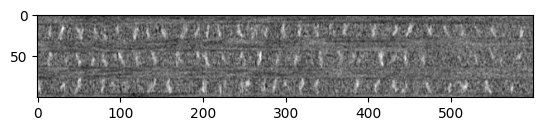

In [17]:
## define layers 

# range(900,1500)
layers =[[ (900,1500),(50,150), (60,70)],]

for layer in layers:
    x,y,z = layer
    print(x)
    img = data[x[0]:x[1],y[0]:y[1],80]

plt.imshow(img.transpose(1,0),cmap='gray')

(900,)
crack density: 4.5351
7.497000000000001


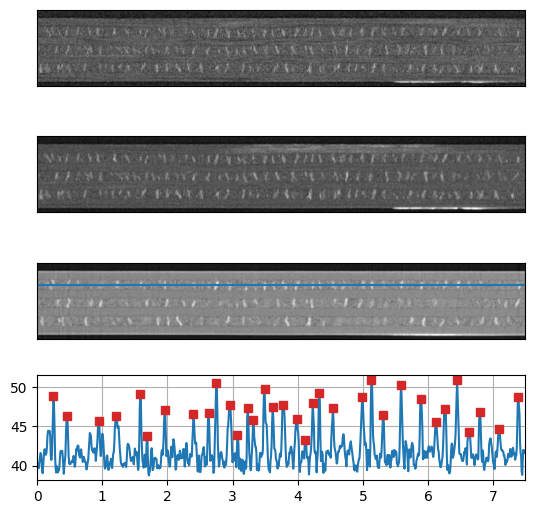

In [18]:
# from matplotlib.patches import Rectangle

fig,axs = plt.subplots(4,1,figsize=(6.3,6.3))
axs = axs.flatten()

scale = 0.00833

subvol = data[600:1500,30:170,60:300]
subvol_max = data_max[600:1500,30:170,60:300]

## display the data 
axs[0].imshow(subvol[:,:,10].transpose(1,0),cmap='gray')
axs[1].imshow(subvol_max[:,:,10].transpose(1,0),cmap='gray')
axs[2].imshow(np.median(subvol_max[:,:,:],axis=2).transpose(1,0),cmap='gray')


layers =[(40),
    # (75),
    # (105)
    ]


for n, layer in enumerate(layers):
    y = layer
    axs[2].plot([0,899],[y,y])
    layer_data = np.mean(subvol_max[:,:,:],axis=2).transpose(1,0)[y,:]
    
    print(layer_data.shape)
    
    axs[3].plot(np.linspace(0,len(layer_data)-1,len(layer_data))*scale,layer_data)
    peaks, _ = find_peaks(layer_data,
        prominence=4,distance=1)
    axs[3].plot(peaks*scale,layer_data[peaks],"s",color = "tab:red")
    # axs[2].plot(peaks,[y]*len(peaks),"*",color = "tab:red")
    print("crack density: %3.4f" %(len(peaks)/len(layer_data)/scale))
    
    
    df1 = pd.DataFrame({'x':peaks*scale,'y':layer_data[peaks]})
    df1.to_csv('layer_%s_peaks.csv' %n,index=False)
    df2 = pd.DataFrame({'x':np.linspace(0,len(layer_data)-1,len(layer_data))*scale,'y':layer_data})
    df2.to_csv('layer_%s_data.csv' %n,index=False)

axs[3].set_xlim(0,len(layer_data)*scale)
axs[3].grid()

print(len(layer_data)*scale)
for ax in axs[:3]: ax.axes.get_xaxis().set_ticks([]);ax.axes.get_yaxis().set_ticks([])

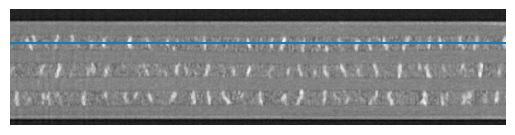

In [90]:


plt.imshow(np.median(subvol_max[:,:,:],axis=2).transpose(1,0)[:,0:600],cmap='gray')
plt.plot([0,599],[40,40])
plt.axis('off')

plt.savefig('exp_contrast_02_line.png',dpi=300)

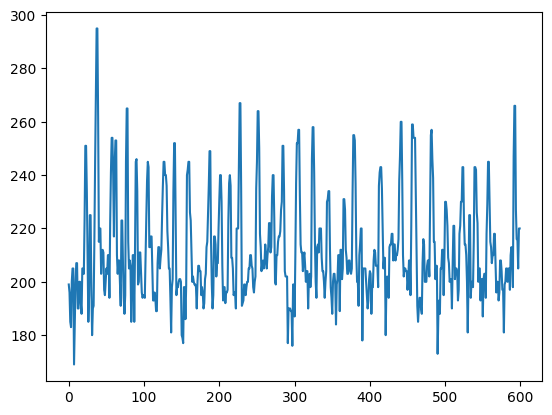

In [42]:
plt.plot(np.sum(data_tmp[900:1500,70,80:85],axis=1))

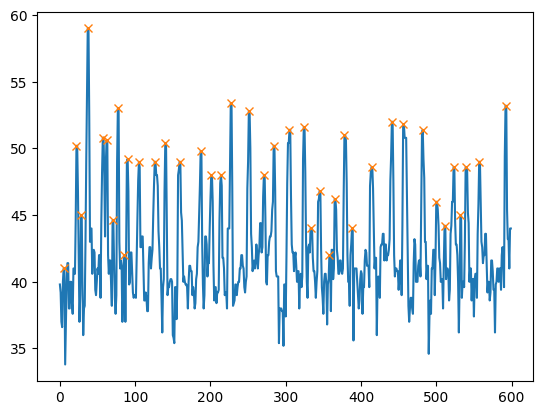

8.003201280512204


In [43]:


layer = np.mean(data_tmp[900:1500,70,80:85],axis=1)

peaks, _ = find_peaks(layer,prominence=4)

plt.plot(layer)

plt.plot(peaks, layer[peaks], "x")



plt.show()
print(len(peaks)/600/0.00833)

## Binarization

In [35]:
threshold_value = filters.threshold_otsu(subvolume)

print(threshold_value)
threshold_value_manually = 43

data_binary = subvolume > threshold_value_manually

# print(np.unique(data_binary))

37


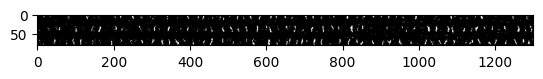

In [36]:
plt.imshow(data_binary[:,:,0].transpose(1,0),cmap='gray')

In [46]:
data_binary2 = ndi.binary_dilation(data_binary)
data_binary2 = ndi.binary_fill_holes(data_binary2)
# data_binary2 = ndi.binary_opening(data_binary2)

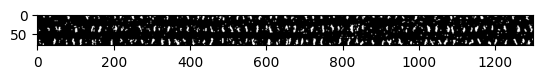

In [47]:
plt.imshow(data_binary2[:,:,0].transpose(1,0),cmap='gray')

In [49]:


data_tmp = data_binary2.astype(int)
# Create a PyVista uniform grid
grid = pv.UniformGrid()

# Define the dimensions of the grid
dims = subvolume.shape
grid.dimensions = (dims[2], dims[1], dims[0])

# Set the spacing (uniform grid assumes equal spacing in all directions)
spacing = (1.0, 1.0, 1.0)
grid.spacing = spacing

# Set the origin (location of the grid in space)
origin = (0.0, 0.0, 0.0)
grid.origin = origin

# Create a PyVista data array from the NumPy array
# point_data = pv.numpy_to_texture(data)

# Add the point data to the grid
grid.point_data["data"] = subvolume.ravel()
grid.point_data["predictions"] = data_tmp.ravel()
# grid.point_data["weft"] = data[1,:,:,:].ravel()
# grid.point_data["fill"] = data[2,:,:,:].ravel()
# Export the uniform grid to a VTS file
grid.save(file + "_subvolume.vtk")
grid.plot()
print("VTS file 'output.vtk' has been created.")

Widget(value="<iframe src='http://localhost:42983/index.html?ui=P_0x7f9a4ea351e0_7&reconnect=auto' style='widt…

VTS file 'output.vtk' has been created.


## Compute Edge Gradients

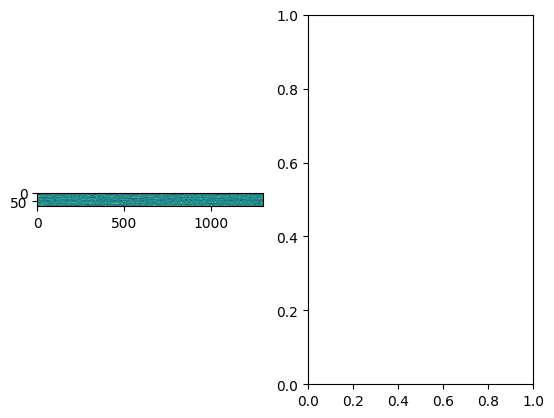

In [121]:
fig,axs = plt.subplots(1,2)
axs = axs.flatten()
slice = subvolume[:,:,50]


edges_prewitt = ndi.prewitt(slice, axis=1)
edges_sobel = ndi.sobel(slice, axis=1)

k = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])

edges_conv = ndi.convolve(slice, k, mode='constant', cval=0.0)


threshold_value_prewitt = filters.threshold_otsu(edges_prewitt)

binary_prewitt = edges_prewitt > threshold_value_prewitt



axs[0].imshow(edges_prewitt.transpose(1,0))
# axs[1].imshow(edges_sobel)
# axs[2].imshow(edges_conv)

# axs[3].imshow(binary_prewitt,cmap='gray')

In [14]:
threshold_value = filters.threshold_otsu(data)

binary_data = data > threshold_value

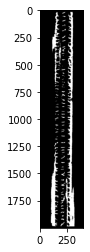

In [15]:
plt.imshow(binary_data[150,:,:],cmap='gray')

In [23]:
edges_x = ndi.sobel(data, axis=0)
edges_y = ndi.sobel(data, axis=1)
edges_z = ndi.sobel(data, axis=2)

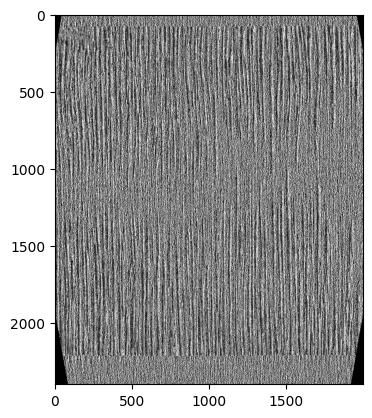

In [26]:
plt.imshow(edges_y[:,:,150],cmap='gray')

In [33]:
threshold_value = filters.threshold_otsu(edges_y)

binary_data = edges_y > threshold_value*1.1


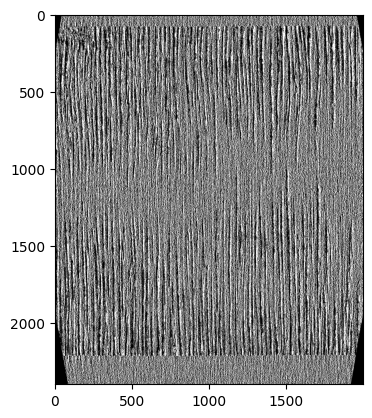

In [35]:
plt.imshow(binary_data[:,:,150],cmap='gray')

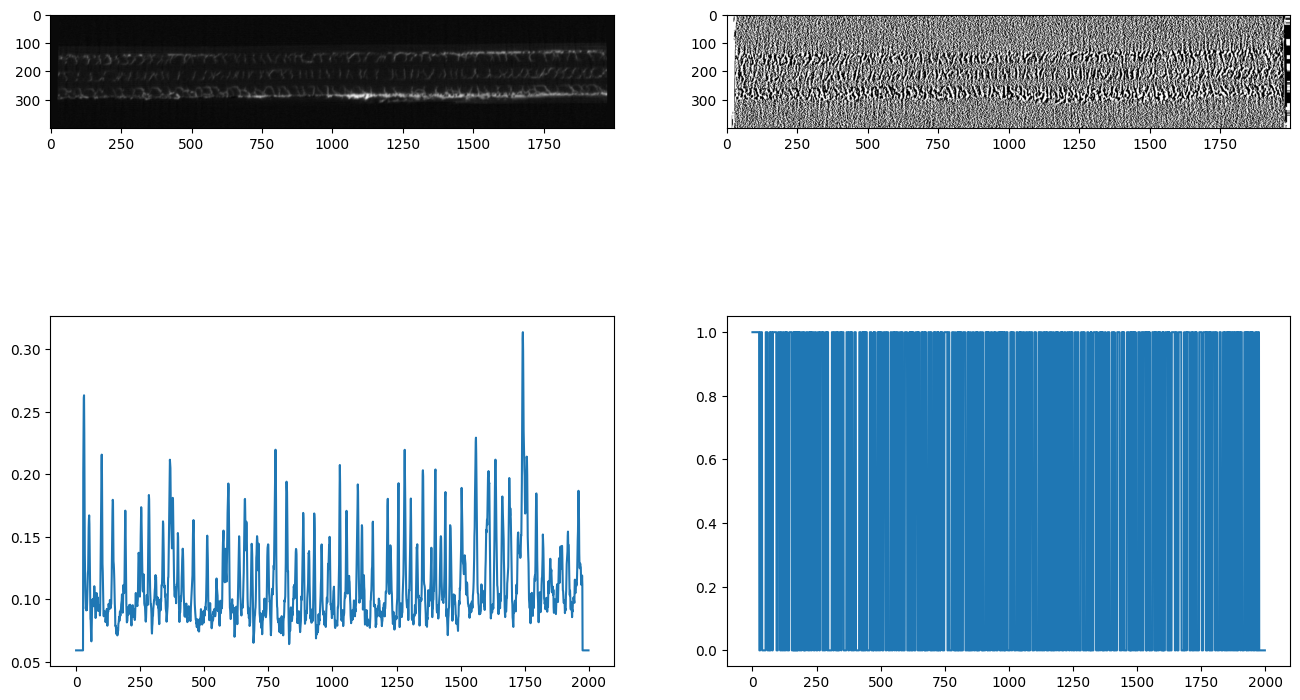

In [181]:
from skimage.draw import line as draw_line



fig, axs = plt.subplots(2,2,figsize=(16,10))
axs = axs.flatten()


axs[0].imshow(image.transpose(),cmap='gray')
axs[1].imshow(binary.transpose(),cmap='gray')

axs[2].plot(image[:,210])
axs[3].plot(binary[:,210])
